In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.ndimage import label, binary_closing, gaussian_filter1d, binary_dilation

#### Load Example Data from KPLO Spacecraft 

In [2]:
"Load Data"
data = np.load("b_kplo.npy") # X axis
print(np.isnan(data).sum())
B = data[1:,2,:25000]
sample_rate = 1

0


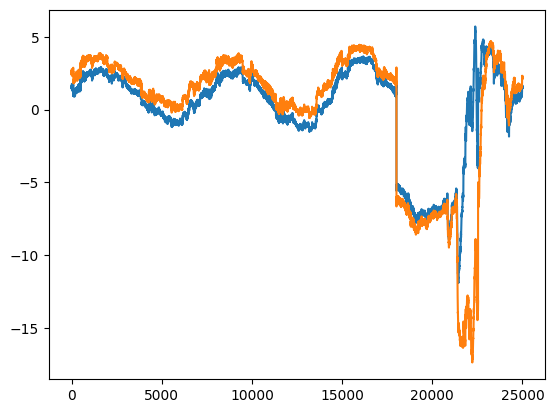

In [3]:
# fill in missing data
#B[0] -= np.mean(B[0]);  B[1] -= np.mean(B[1])
B = (B.T - np.mean(B, axis=1)).T
plt.plot(B.T)

In [4]:
"Wavelet Transform"
transform = Transform(
    data = B[0],
    fs = sample_rate,
    wavelet=Morlet(1,2),
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
    Mc = 1,
    scales='dyadic',
    real = False
)

7500.0 1.0 0.25 1.0


In [5]:
transform.j_channels

array([   -1,     0,     1, ..., 18743, 18744, 18745], shape=(18747,))

Text(0.5, 0, 'Frequency Channel')

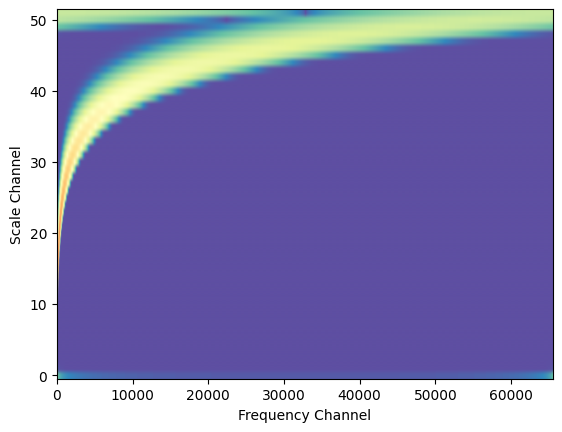

In [6]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

In [35]:
transform.enforce_orthagonality(eps=1e-1)

In [36]:
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

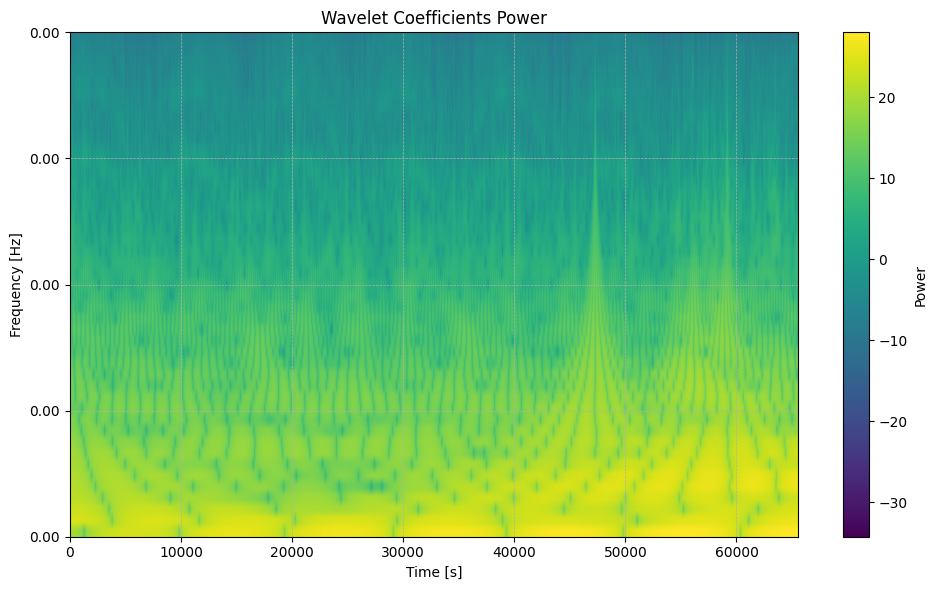

In [37]:
transform.scalogram(w2)

In [38]:
transform.freqs

array([ 0.00000000e+00,  1.52587891e-05,  3.05175781e-05, ...,
       -4.57763672e-05, -3.05175781e-05, -1.52587891e-05], shape=(65536,))

In [39]:
D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2 / C1                          # shape (J,)
# (optionally force to real if you know K is real:)
K_hat = K_hat.real

# 3) stray‑field estimate A(s,τ) (eq 9)
A = D / (K_hat[:,None] - 1)              # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

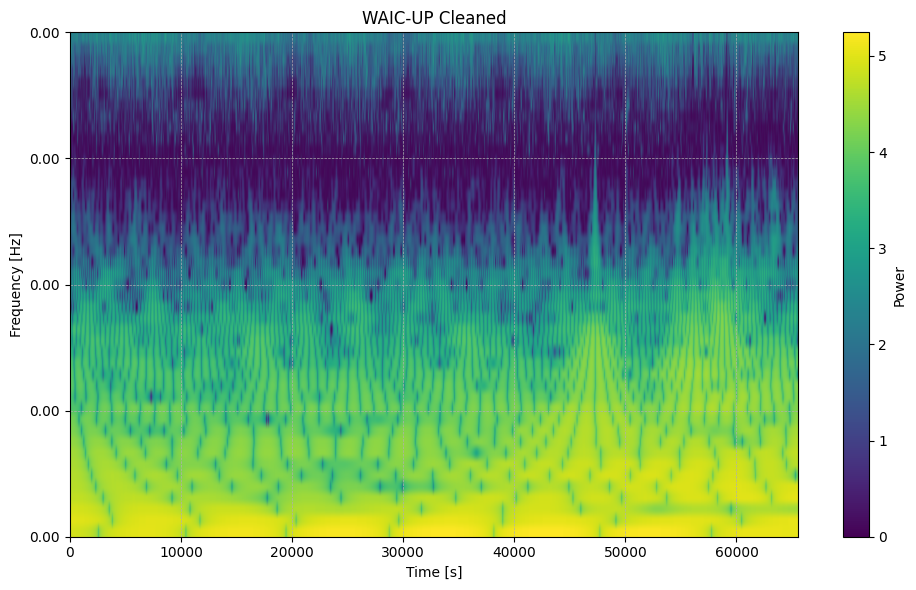

In [40]:
transform.scalogram(np.log(np.abs(X)+1e-3), vmin=0,  title = 'WAIC-UP Cleaned')

c:\Users\aphoffm2\OneDrive - NASA\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:235: RuntimeWarning: invalid value encountered in divide
  XhatFreq = numerator / self.Sfreq


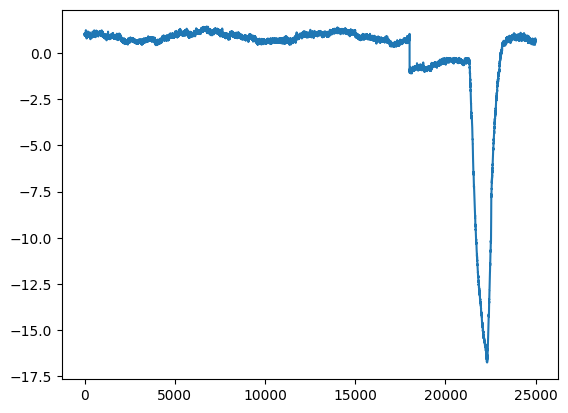

In [41]:
result = transform.inverse(np.copy(X))
plt.plot(B[1]- B[0])
plt.plot(result)

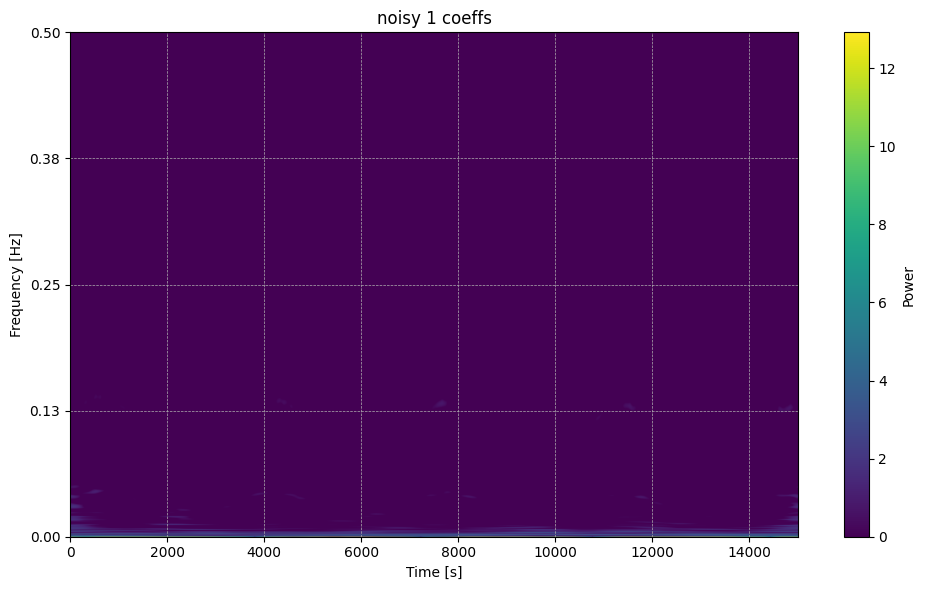

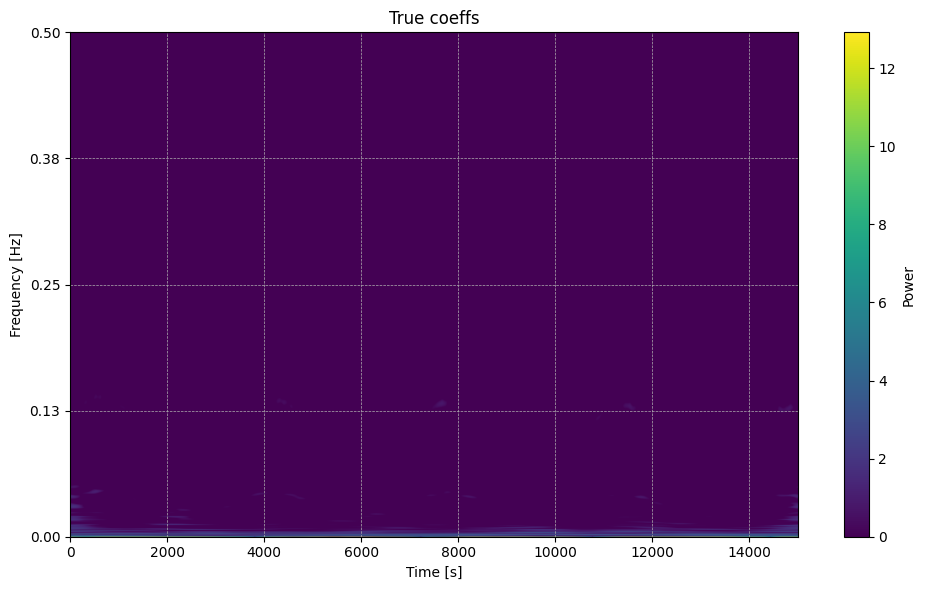

KeyboardInterrupt: 

In [51]:
transform.scalogram(w1, vmin=0,  title = 'noisy 1 coeffs')
transform.scalogram(transform.forward(B[0]), vmin=0, title = 'True coeffs')
transform.scalogram(w_clean, vmin=0, title = 'Cleaned Signal coeffs')
w = transform.forward(result)
transform.scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')

'\nThis chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? \n'

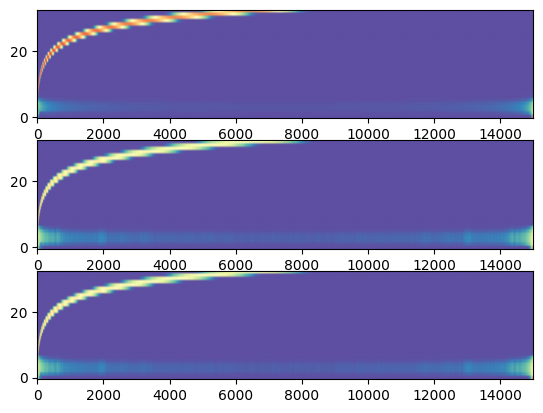

In [20]:
# https://www.sciencedirect.com/science/article/abs/pii/S0888327002915244 Aliasing??
fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[1].imshow(np.log(np.abs(np.fft.fft(w_clean, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[2].imshow(np.log(np.abs(np.fft.fft(w1, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')


"""
This chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? 
"""

In [5]:
transform.b

1

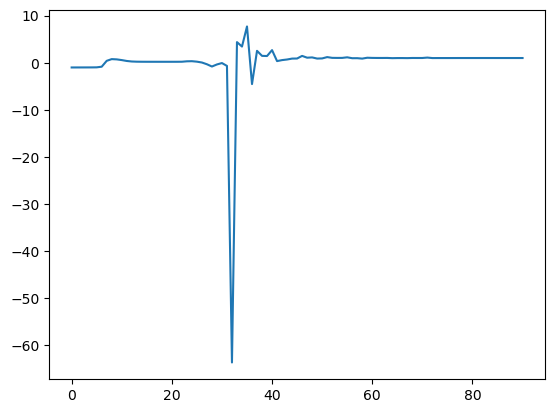

In [6]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

#### WAICUP


(2.3926963860090864+0j)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


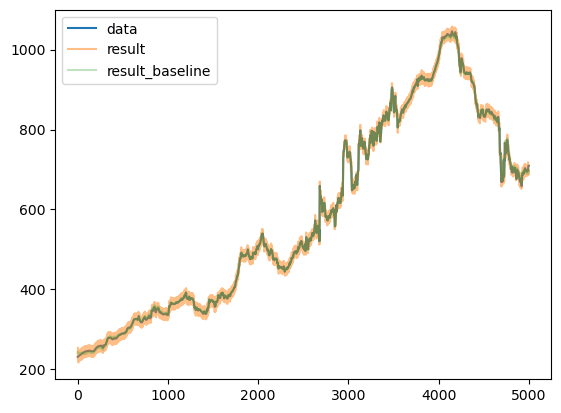

In [35]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend =True
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()

In [8]:
1/6.10351562e-03



163.84000013421775